# POP Atlantic BSF for 0.1-degree
**Input Data:** Monthly POP output timeseries files  
**Output Data:** Monthly mean BSF timeseries  
**Description:** Computes (approximate) Atlantic BSF offline from POP history files using simple zonal integral.  
**Date:** April 2023  
**Creator:** Steve Yeager
**Updated:** -
**Note:** -

In [1]:
%load_ext autoreload
%autoreload 2
import cftime
import copy
import dask
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import os
import pop_tools
import time
import xarray as xr 
from MOCutils import popmoc

In [2]:
from dask.distributed import wait
dask.__version__

'2022.11.0'

In [3]:
pop_tools.__version__

'2021.5.28.post43'

In [7]:
# Close out Dask Cluster and release workers:
client.shutdown()

In [4]:
# TODO: optimize dask resources

def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GiB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB', 
        account='P93300313',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33803 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/33803/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/33803/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41531,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/33803/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

# Get the required variables 

In [14]:
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002/ocn/proc/tseries/month_1/'
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003/ocn/proc/tseries/month_1/'
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP45/HR/b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
# fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP26/HR/b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'

# fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.VVEL.200601-210012.nc'
fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.VVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
# fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
dsV = xr.open_dataset(fin, chunks={'time':1,'nlat':150})  # TODO: try chunking by nlat
dsV = time_set_midmonth(dsV,'time')

fgrd = '/glade/work/fredc/cesm/grid/POP/grid.3600x2400x62.nc'
ds_grid = xr.open_dataset(fgrd)

In [15]:
dsV.VVEL

<xarray.DataArray 'VVEL' (time: 1140, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<open_dataset-516df631bd1cfd8299ccd483f000403dVVEL, shape=(1140, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 150, 3600), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(150, 3600), meta=np.ndarray>
  * time     (time) object 2006-01-15 00:00:00 ... 2100-12-15 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Velocity in grid-y direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

In [16]:
vvel = dsV['VVEL']
vvel = vvel.where(vvel<1.e30,0)/100.

### Region Mask & Grid Fields

In [17]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskatl = (rmask==6) | (rmask==8) | (rmask==9)

In [18]:
%%time
dz = ds_grid['dz'].persist()/100.
kmt = ds_grid['KMT'].fillna(0).persist() 
dxu = ds_grid['DXU'].persist()/100.
print('got dz and kmt')
# Slow step (~12 mins)
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)
print('got dzt dzu')

got dz and kmt
got dzt dzu
CPU times: user 13.9 s, sys: 11.8 s, total: 25.7 s
Wall time: 27.7 s


In [19]:
tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])

### Compute BSF

In [34]:
%%time
sv = (vvel*dzt*dxu).sum('z_t')
sv.attrs['units']='m^3/s'
sv_atl = sv.where(rmaskatl).drop(['TLONG','TLAT'])
bsf = sv_atl.cumsum('nlon')/1.e6
bsf = xr.where(rmaskatl,bsf,0)
bsf = bsf.assign_coords({'ULAT':ulat,'ULONG':ulon})
bsf = bsf.where(kmt!=0).drop(['TLONG','TLAT'])
bsf = bsf.assign_attrs({'units':'Sv','long_name':'Barotropic Streamfunction'}).rename('BSF')
bsf = bsf.transpose('time','nlat','nlon')

CPU times: user 7.06 s, sys: 1.69 s, total: 8.74 s
Wall time: 10.9 s


In [35]:
%%time
bsf = dask.optimize(bsf)[0]

CPU times: user 4.25 s, sys: 58.2 ms, total: 4.31 s
Wall time: 4.5 s


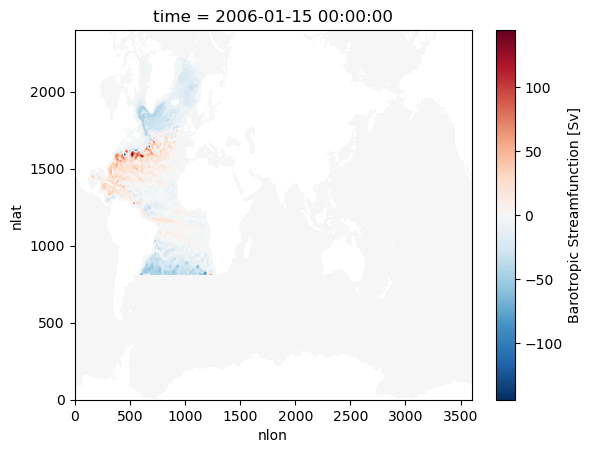

In [30]:
bsf.isel(time=0).plot()

## Output to netcdf

In [36]:
%%time
# Save to netcdf
dsout = bsf.isel(time=slice(0,12)).to_dataset()
#fout = fin.replace('VVEL','BSF')
fout = '/glade/scratch/yeager/'+os.path.split(fin)[-1].replace('VVEL','BSF')
dsout.to_netcdf(fout,unlimited_dims='time')

CPU times: user 6.77 s, sys: 2.34 s, total: 9.1 s
Wall time: 34 s
